# Notebook to demonstrate working with the DRI Mapping Dataset

This notebook is written in Python. It is typically run on the free Binder service as outlined in:

https://github.com/net-zero-dri/dri-mapping-dataset/blob/main/USAGE.md

The software dependencies for running the notebook are defined in this Conda environment file:

https://github.com/net-zero-dri/dri-mapping-dataset/blob/main/environment.yml


**The notebook presents the following features:**

1. Loading the data
2. Visualisation using pie charts
3. Generating scatter plots
4. Investigating relationships (correlations)

## Let's start by importing the required libraries

In [1]:
# Import standard library packages
import math
import re

# Import data analysis and visualisation packages
import numpy as np
import pandas as pd

from bokeh.palettes import Category20c, Category20
import matplotlib.pyplot as plt

# if using a Jupyter notebook, include:
%matplotlib inline

# import seaborn as sn - is only used if generating correlation plots

## 1. Loading the data

Load the dataset, and the column descriptions file which includes longer descriptions of the column names (which can be used when visualising the data).

In [2]:
# Set variables for the CSV file paths
dset_path = "dri_mapping_dataset.csv"
columns_path = "column_descriptions.csv"

# Load the main dataset as a Pandas DataFrame ("df"), and the column descriptions
# as a separate DataFrame ("col_df")
df = pd.read_csv(dset_path)
col_df = pd.read_csv(columns_path)

# Check there are 44 valid records and there are 40 columns
assert len(df) == 44
assert len(col_df) == 40

# Check the column names in the main dataset match those named in the columns file
assert list(df.columns) == list(col_df["Column name"])

# There were 51 total responses, but only 44 were valid/relevant
TOTAL_RESPONSES = 51
N_VALID_RECORDS = len(df)

Let's see what the columns are called, and their longer descriptions...

In [3]:
col_df

,Column name,Descriptive name,Original survey question
0,record_no,Record number,Not applicable
1,tier_cat,Tier Category,"1.8 Based on the EPSRC ""Tier"" categorisation o..."
2,region,UK Region,"1.9 Location (e.g. town, city or county)"
3,main_rcs,Research Council funding,2.1.a Which are the main Research Councils (...
4,ukri_pc,UKRI stake in the facility (as %),2.2 Do you know the percentage UKRI stake in t...
5,n_users,Number of users,2.3 Do you know how many individual users your...
6,purpose,Broad purpose,3.1.a Does your facility support general-purpo...
7,primary_func_facility,Primary function of facility,3.3.a How would you describe your facility i...
8,main_physical_comp,Main physical infrastructure,3.4.a What is the predominant component of p...
9,cool_sys,Cooling system type,4.1.a What type of cooling system do you use?


And let's view the first 3 rows of the main dataset:

In [4]:
df.head(3)

,record_no,tier_cat,region,main_rcs,ukri_pc,n_users,purpose,primary_func_facility,main_physical_comp,cool_sys,...,planned_environ_consid,purchase_environ_consid,disposal_environ_consid,usr_knowledge,budget_training,training_impact,usr_nrg_ftprt,imag_user_supp,train_needs,need_std_cert
0,Record 2,No Tier,Southern England,NERC,60-80,0-100,Specific scientific focus,Other,Other,Air cooled,...,NaN,Yes,Yes - disposal/re-use policies,Health & Safety,No,Yes,Yes - estimated energy usage,New facility with optimised design/technology,Understand Scope 3 Emissions,No
1,Record 4,No Tier,Northern England,BBSRC,Unknown,0-100,General purpose,Storage,Server (CPU),Air cooled,...,No,No control over policy,No control over policy,No,No,Not yet,No,Monitor at user level; recycle all plastics,Training on energy efficiency/environmental su...,Yes
2,Record 5,No answer,Southern England,NERC,80-100,No answer,General purpose,Other,Other,No answer,...,No answer,No answer,No answer,No answer,No answer,No answer,No answer,No answer,No answer,No answer


We can get a quick overview of the dataset, seeing the counts, number of unique values and top response to each question:

In [5]:
df.describe()

,record_no,tier_cat,region,main_rcs,ukri_pc,n_users,purpose,primary_func_facility,main_physical_comp,cool_sys,...,planned_environ_consid,purchase_environ_consid,disposal_environ_consid,usr_knowledge,budget_training,training_impact,usr_nrg_ftprt,imag_user_supp,train_needs,need_std_cert
count,44,44,44,43,44,44,44,43,44,42,...,35,42,43,44,44,44,42,38,39,43
unique,44,5,6,9,7,8,4,5,9,9,...,10,5,8,13,4,6,8,16,15,7
top,Record 2,No Tier,Southern England,NERC,80-100,0-100,Specific scientific focus,HPC,Server (CPU),Air cooled,...,No answer,Yes,Yes - disposal/re-use policies,No,No,No answer,No,No answer,No answer,Yes
freq,1,21,19,11,24,14,22,17,11,20,...,10,15,17,16,35,31,22,11,12,21


## 2. Visualisation using pie charts


In [6]:
# Define functions for getting the data (for a specific column), and for plotting it

def drop_missing(dframe):
    """
    Removes invalid responses from the DataFrame ('No answer', 'N/A')
    """
    cols = list(dframe.columns)
    for col in cols:
        dframe = dframe[~dframe[col].isin(["No answer", "N/A"])]

    return dframe


def get_pie_cat_data(col_name):
    """
    Extracts the source field from the dataset, then returns data
    ready for plotting in a pie chart.
    """
    if col_name not in df.columns:
        raise Exception(f"Unknown column: {col_name}")

    filtered_field = drop_missing(df[[col_name]])[col_name]
    counts = filtered_field.value_counts()
    
    data = pd.Series(counts).reset_index(name='value').rename(columns={'index':col_name})
    data['angle'] = data['value'] / data['value'].sum() * 2 * math.pi
    
    # Sort, if we can
    try:
        data = data.sort_values(col_name, key=lambda col: col.str.lower())
    except Exception as exc:
        pass

    data['color'] = Category20c[len(data)]    
    return data, len(filtered_field)


def plot_pie_chart(col_name):
    """
    Plot a pie chart of the given column: `col_name`.
    """
    data, n_records = get_pie_cat_data(col_name)
    fig, ax = plt.subplots()
    
    patches, texts, autotexts = ax.pie(data["value"], labels=data[col_name], autopct='%1.1f%%', 
                                       pctdistance=0.75,
                                       colors=data["color"], explode=[0.01] * len(data))

    [_.set_fontsize(8) for _ in texts]
    [_.set_fontsize(8) for _ in autotexts]
    ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
    
    try:
        title = col_df[col_df["Column name"] == col_name]["Descriptive name"].iloc[0] + f" ({col_name})"
    except Exception as exc:
        title = col_name

    ax.set_title(f"{title}\n[{n_records} valid responses from {TOTAL_RESPONSES}]")
    plt.show()

Let's try out the plotting with a few interesting columns.

Firstly, let's see the spread of research council funding across the responses:

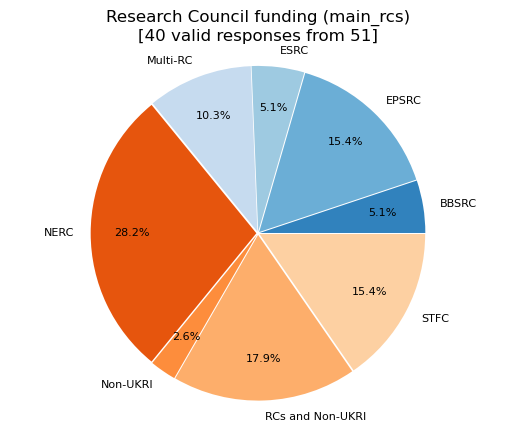

In [7]:
plot_pie_chart("main_rcs")

Here is the number of CPUs, demonstrating the range of sizes of facilities:

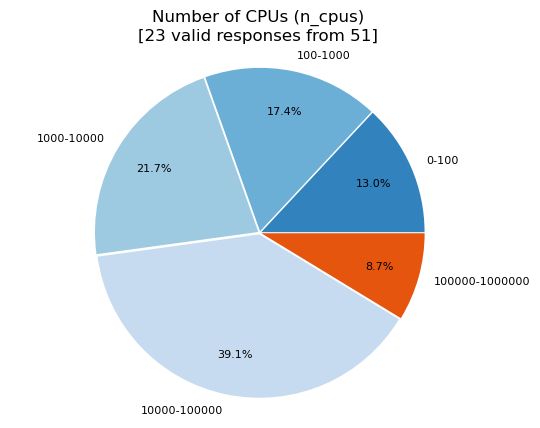

In [8]:
plot_pie_chart("n_cpus")

Interestingly, very few facility managers had direct control of their choice of energy supply:

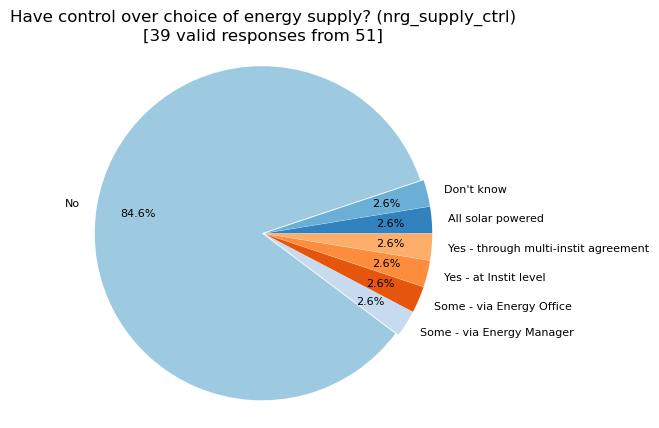

In [9]:
plot_pie_chart("nrg_supply_ctrl")

The spread of energy usage per year was:

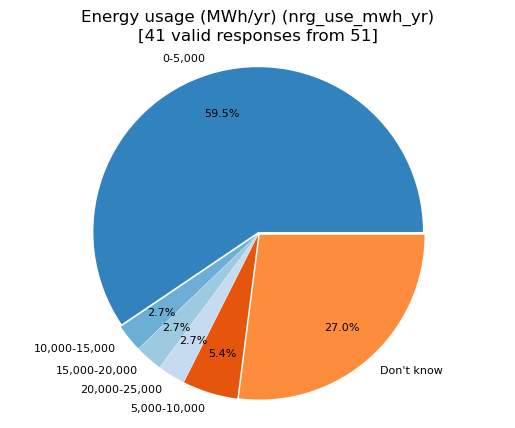

In [10]:
plot_pie_chart("nrg_use_mwh_yr")

## 3. Generating scatter plots

We can also generate a scatter plot for data of interest, such as the number of users:

Text(0.5, 0, 'Facility')

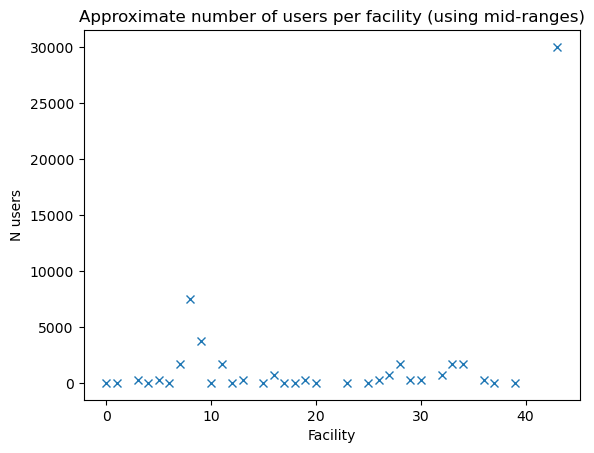

In [11]:
# The data is given in ranges, we would like it in numeric form, let's write a 
# function to take the mid-range of each range

def get_mid_ranges(series):
    """
    Convert string ranges into mid-range numbers, e.g.:
    * 0-10 --> 5
    * 10-50 --> 35
    """
    values = []
    
    for s in series:
        try:
            start, end = [float(x.replace(",", "")) for x in str(s).split("-")]
            values.append((end + start) / 2)
        except:
            values.append(None)
            
    return pd.Series(values)


# Convert to numeric
n_users_numeric = get_mid_ranges(df.n_users)

# Plot as scatter plot
n_users_numeric.plot.line(ls="None", marker="x")
plt.title("Approximate number of users per facility (using mid-ranges)")
plt.ylabel("N users")
plt.xlabel("Facility")

## 4. Investigating relationships (correlations)

This published dataset has been generated by mapping the original responses to ranges and categories. This approach limits how one can use existing data analysis tools to investigate correlations. 

The original dataset, which holds the exact numeric responses, was analysed using the correlation function available on a `Pandas DataFrame`. The result is included below as an image. 

It was generated with the following code:

```
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt


def plot_corr_matrix(df):
    "Plot correlation matrix of all numeric values."
    fig, ax = plt.subplots(figsize=(10, 10))   
    corr_matrix = df.corr()
    sn.heatmap(corr_matrix, annot=True, ax=ax)
    plt.draw()

    ax.xaxis.set_ticks_position('top')
    xtick_labels = map_labels(ax.get_xticklabels())
    ytick_labels = map_labels(ax.get_yticklabels())

    ax.set_xticklabels(xtick_labels, rotation=90)
    ax.set_yticklabels(ytick_labels)
    plt.show()

```

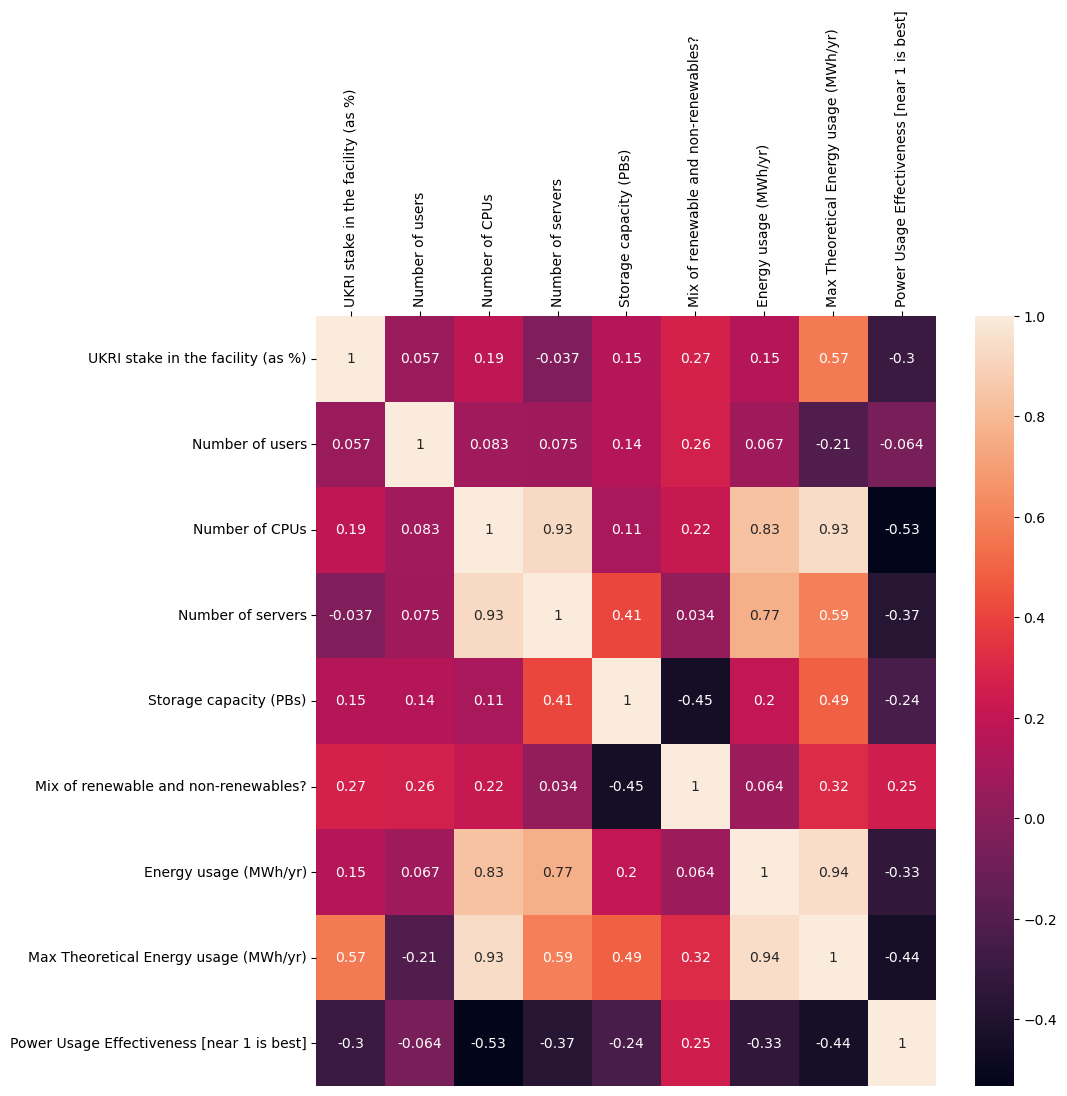

In [12]:
from IPython import display
display.Image("correlation_plot.png")

**According to the matrix, there is high correlation between N CPUs and energy usage.**

The relevant columns are:
- `n_cpus`
- `nrg_use_mwh_yr`

We can use the `get_mid_ranges` function from above to plot these:

Text(0, 0.5, 'Energy usage (MWh/yr) [mid-range]')

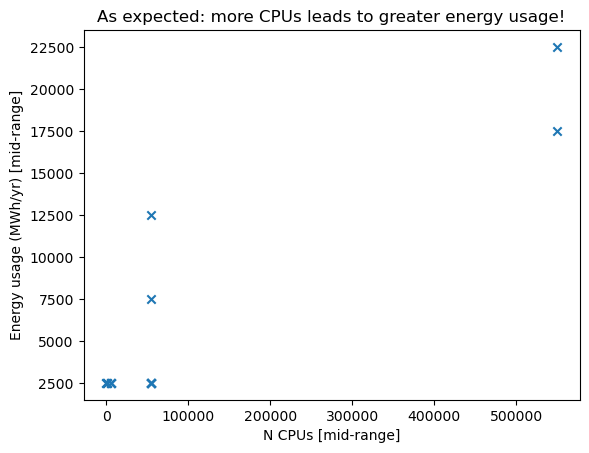

In [13]:
x = get_mid_ranges(df.n_cpus).tolist()
y = get_mid_ranges(df.nrg_use_mwh_yr).tolist()


plt.scatter(x, y, marker="x")
plt.title("As expected: more CPUs leads to greater energy usage!")

plt.xlabel("N CPUs [mid-range]")
plt.ylabel("Energy usage (MWh/yr) [mid-range]")

Whilst there are not many data points to draw strong conclusions from, it looks like a correlation will exist between these two features of the dataset.